In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage.morphology
import skimage.measure
import skimage.segmentation
import skimage.feature
import sklearn.preprocessing
import imageio
import glob
import cv2
from scipy.spatial import distance as dist
import pyefd
import math
import sklearn.decomposition
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
from math import atan2, cos, sin, sqrt, pi
from sklearn.svm import *
import sklearn.metrics
import scipy.io as spio

def getOrientation(pts, img):
    
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    
    return angle
def image_preprocessing(filepath):
    img = imageio.imread(filepath)

    otsu_thresh = skimage.filters.threshold_otsu(img)
    img_post = np.where(img< otsu_thresh, img, 0)
    img_post = skimage.morphology.remove_small_objects(img_post, 64)
    img_post = skimage.morphology.opening(img_post, skimage.morphology.disk(15))
    img_post = skimage.morphology.closing(img_post, skimage.morphology.disk(10))
    img_mask = np.where(img_post != 0, 1, 0)
    
    #Segment the image
    img_seg = skimage.measure.label(img_mask, background = 0, connectivity=2)
    
    #Find largest segment
    max_size = 0
    layer = []
    for i in range(1, np.max(img_seg)+1):
        max_temp = np.sum(np.where(img_seg == i, 1, 0))
        if max_temp > max_size:
            max_size = max_temp
            layer.append(i)


    largest_seg = np.where(img_seg == layer[-1], True, False)
    
    #Get image orientation
    cow_mask = np.where(largest_seg == True, 255, 0).astype('uint8')
    src = cow_mask
    contours, _ = cv.findContours(src, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    for i, c in enumerate(contours):
        angle = getOrientation(c, src)
        angle = np.rad2deg(angle)-90
        if angle < -180:
            angle = angle+180


    image_center = tuple(np.array(cow_mask.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated_cow = cv2.warpAffine(cow_mask, rot_mat, cow_mask.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    #crop the new image to be flat on top
    for i in range(np.shape(cow_mask)[0]):
        if np.sum(cow_mask[i, :]) != 0:
            len_top_row = int(np.sum(cow_mask[i, :])/255)
            break

    crop_length = abs(int(len_top_row*np.tan(abs(np.deg2rad(angle)))))
    
    
    cnt, _ = cv2.findContours(rotated_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    max_cnt = max(cnt, key=cv2.contourArea)


    reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

    max_y_crop = np.max(reshaped_contour[::, 0])
    min_y_crop = np.min(reshaped_contour[::, 0])


    max_x_crop = np.max(reshaped_contour[::, 1])
    min_x_crop = crop_length


    if min_x_crop > 10:
        cropped_cow = rotated_cow[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    if min_x_crop < 10:
        cropped_cow = rotated_cow[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    cnt, _ = cv2.findContours(cropped_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    max_cnt = max(cnt, key=cv2.contourArea)
    reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

    b_cow = np.where(cropped_cow>0, 1, 0)
    
    #Rotating the depth image to be the same as the mask
    #depth = imageio.imread(img_names[img_num])
    rotated_depth = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    if min_x_crop > 10:
        cropped_depth = rotated_depth[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
    if min_x_crop < 10:
        cropped_depth = rotated_depth[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]
        
    masked_depth = (b_cow*cropped_depth).astype('uint16')
    
    return masked_depth, b_cow

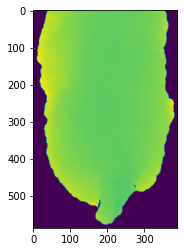

In [37]:
filepath = 'images/depth/usable/4.tiff'
masked_depth, mask = image_preprocessing(filepath)

plt.imshow(masked_depth)